In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras import models, Model
import qkeras
from qkeras import *
from sparsepixels.layers import *
from sparsepixels.utils import *

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

n_val = 10000
X_val = X_train[:n_val]
y_val = y_train[:n_val]
X_train = X_train[n_val:]
y_train = y_train[n_val:]

X_train = np.reshape(X_train, (-1,28,28,1)) / 255.
X_val = np.reshape(X_val, (-1,28,28,1)) / 255.
X_test = np.reshape(X_test, (-1,28,28,1)) / 255.

y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

print("X_train.shape: " + str(X_train.shape))
print("y_train.shape: " + str(y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("y_val.shape: " + str(y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("y_test.shape: " + str(y_test.shape))

X_train.shape: (50000, 28, 28, 1)
y_train.shape: (50000, 10)
X_val.shape: (10000, 28, 28, 1)
y_val.shape: (10000, 10)
X_test.shape: (10000, 28, 28, 1)
y_test.shape: (10000, 10)


no. of active pixels [0]: 151 / 784 = 0.19260204081632654
no. of active pixels [1]: 29 / 1600 = 0.018125
no. of active pixels [2]: 29 / 1600 = 0.018125
no. of active pixels [3]: 1600 / 1600 = 1.0
no. of active pixels [4]: 12 / 1600 = 0.0075


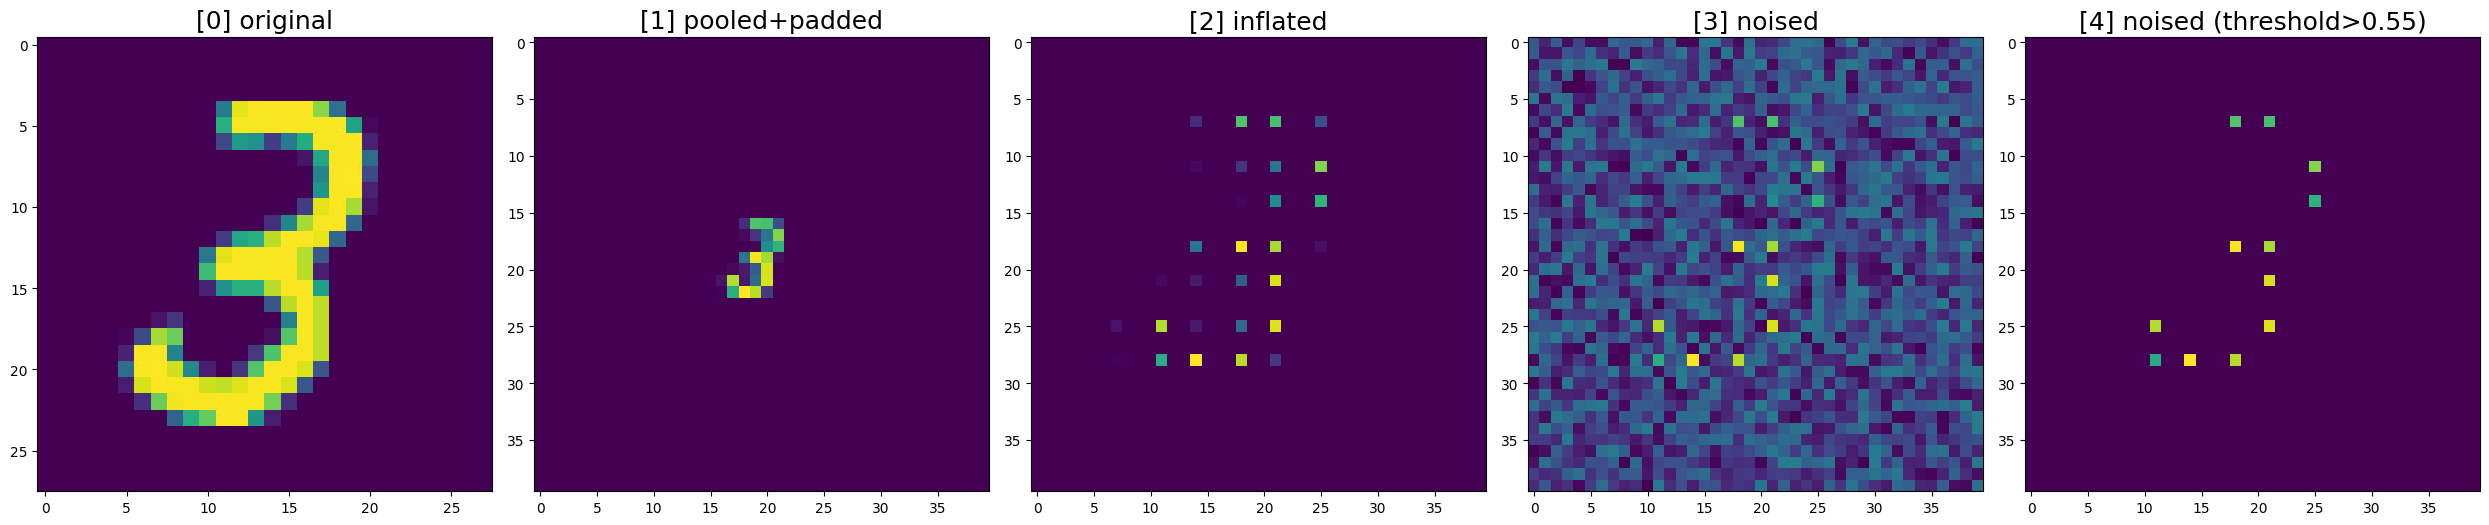

no. of active pixels [0]: 129 / 784 = 0.16454081632653061
no. of active pixels [1]: 28 / 1600 = 0.0175
no. of active pixels [2]: 28 / 1600 = 0.0175
no. of active pixels [3]: 1600 / 1600 = 1.0
no. of active pixels [4]: 9 / 1600 = 0.005625


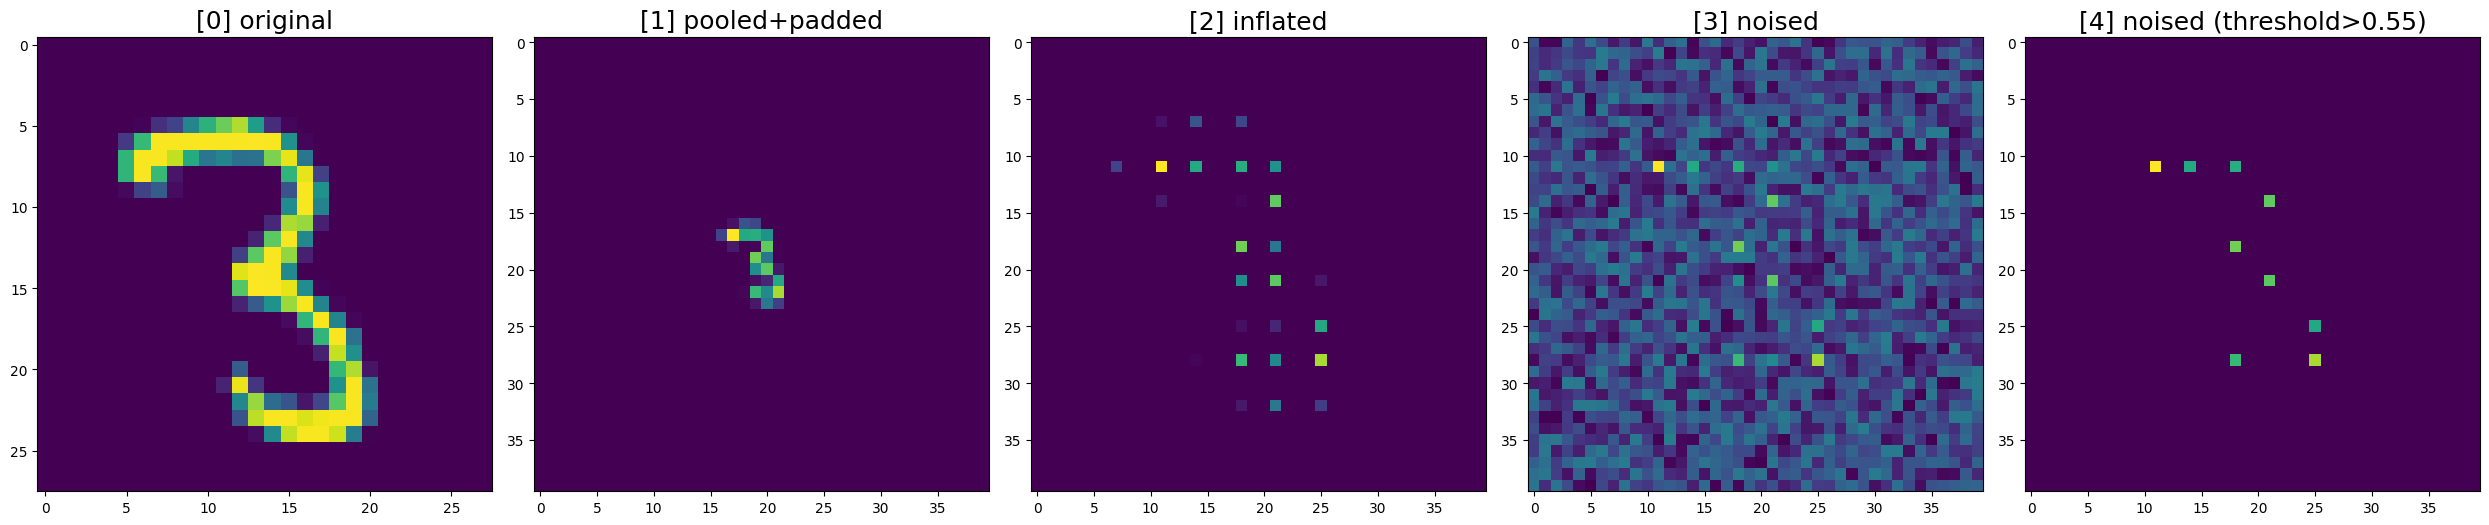

no. of active pixels [0]: 197 / 784 = 0.2512755102040816
no. of active pixels [1]: 31 / 1600 = 0.019375
no. of active pixels [2]: 31 / 1600 = 0.019375
no. of active pixels [3]: 1600 / 1600 = 1.0
no. of active pixels [4]: 15 / 1600 = 0.009375


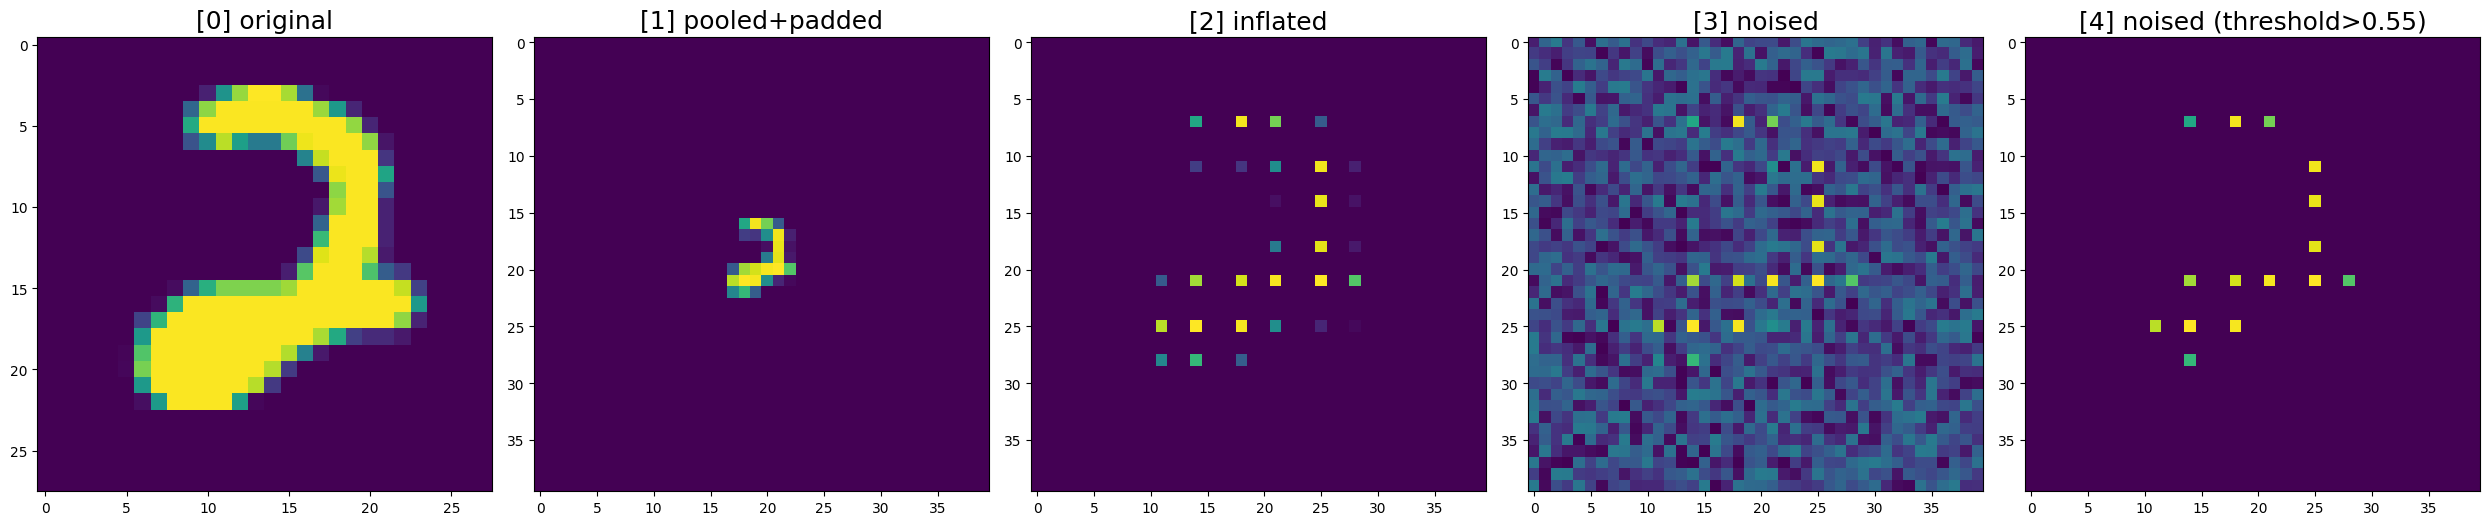

no. of active pixels [0]: 177 / 784 = 0.22576530612244897
no. of active pixels [1]: 32 / 1600 = 0.02
no. of active pixels [2]: 32 / 1600 = 0.02
no. of active pixels [3]: 1600 / 1600 = 1.0
no. of active pixels [4]: 14 / 1600 = 0.00875


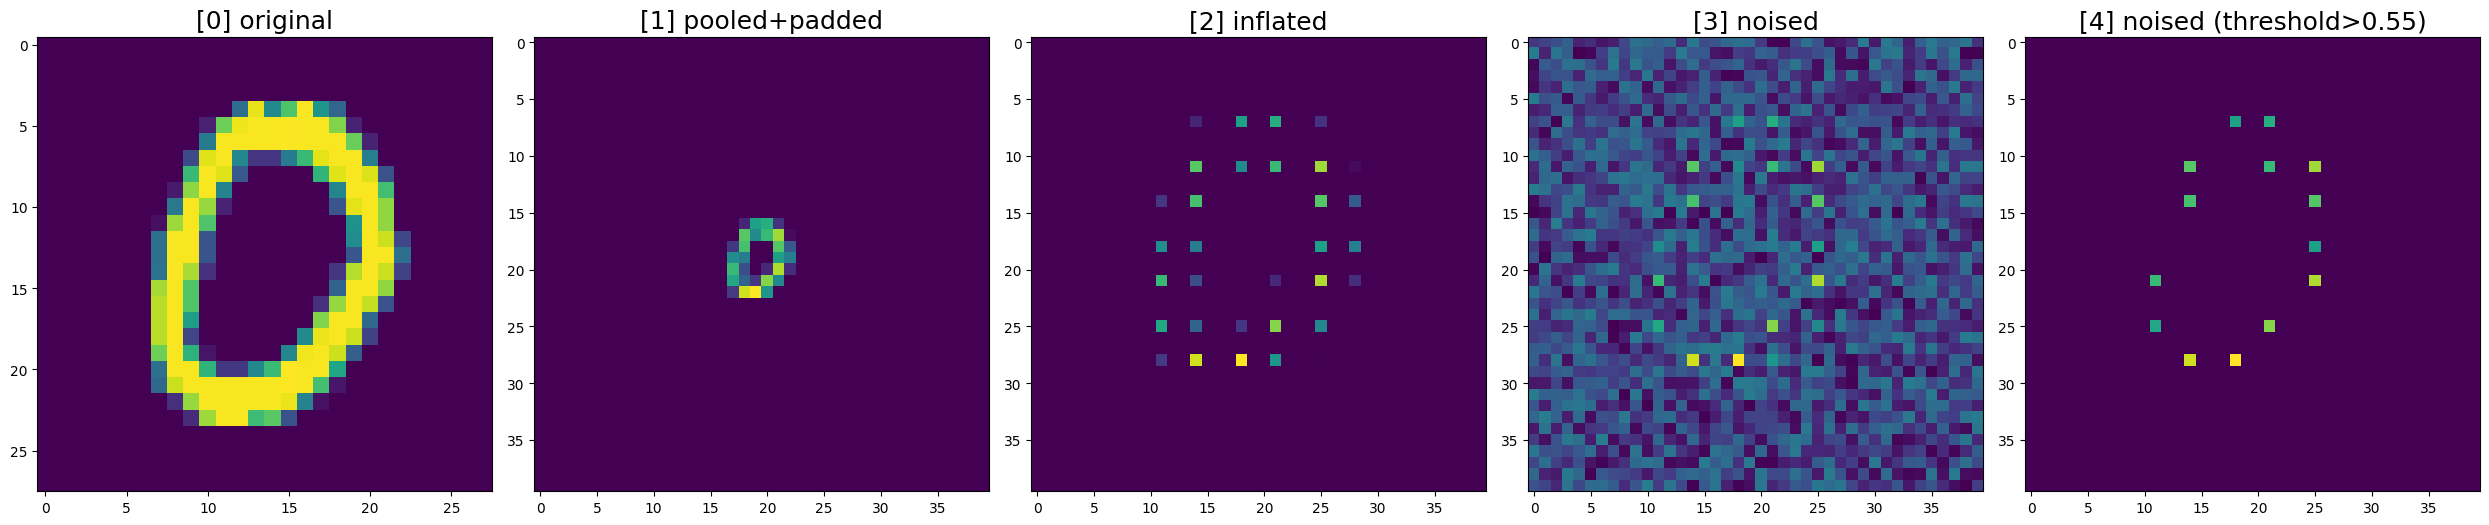

no. of active pixels [0]: 162 / 784 = 0.2066326530612245
no. of active pixels [1]: 26 / 1600 = 0.01625
no. of active pixels [2]: 26 / 1600 = 0.01625
no. of active pixels [3]: 1600 / 1600 = 1.0
no. of active pixels [4]: 13 / 1600 = 0.008125


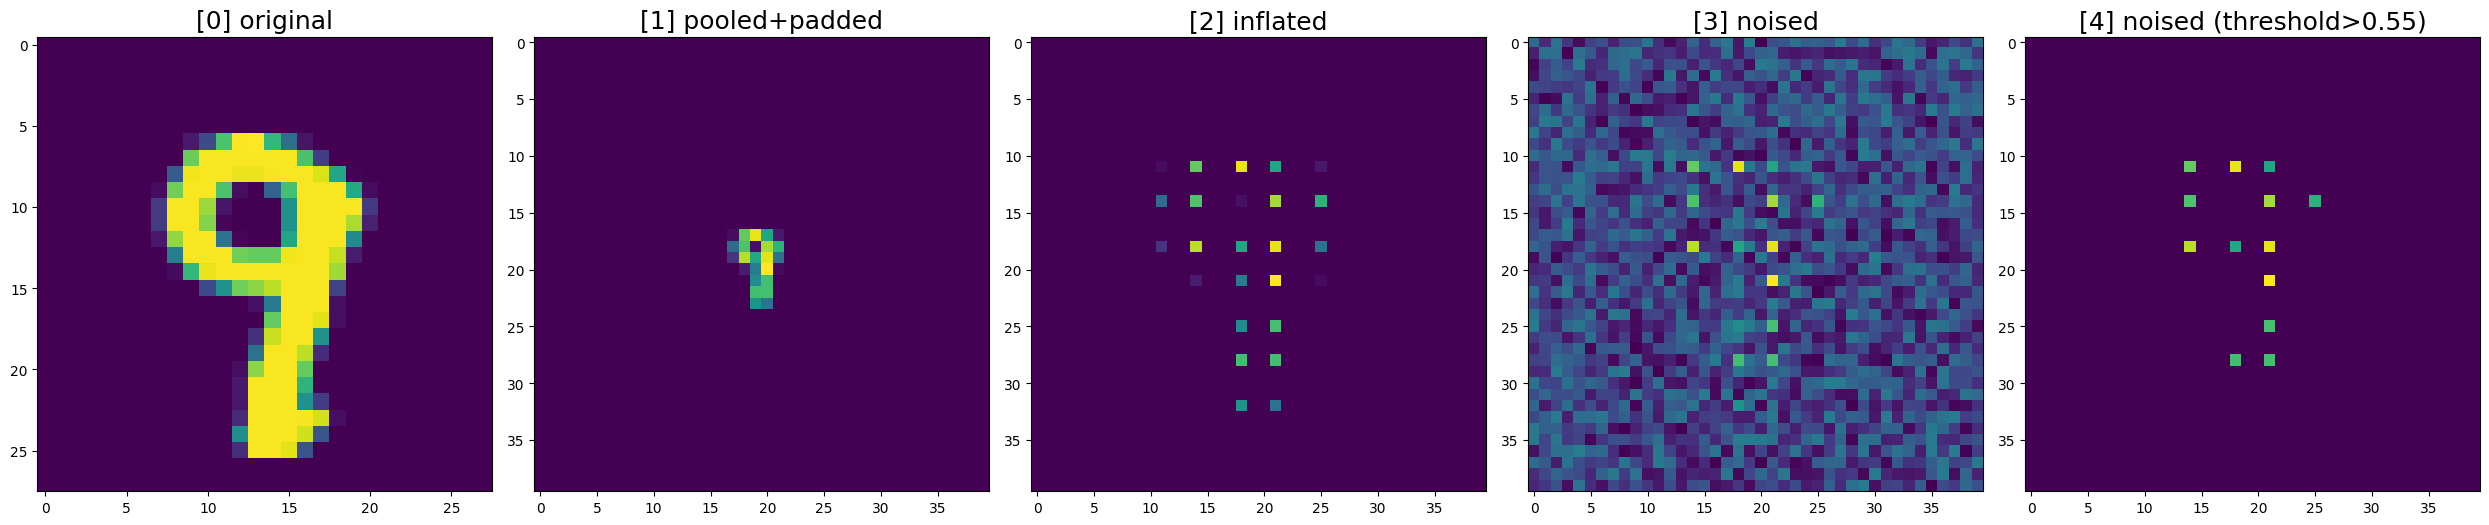

In [2]:
import os
import random
os.environ['PYTHONHASHSEED'] = str(121)
random.seed(121)
tf.random.set_seed(121)
np.random.seed(121)

noise_type='uniform'
#noise_type='poisson'
noise_level=0.42
inflate_factor=3.5
threshold=0.55
target_size_x=40
target_size_y=target_size_x

x_train_pooled = pool_pad_noise_inflate(X_train, pool_size=3, pool_type='avg', target_size=(target_size_x,target_size_y), noise_type=noise_type, noise_level=0, inflate_factor=1)
x_train_pooled_inflated = pool_pad_noise_inflate(X_train, pool_size=3, pool_type='avg', target_size=(target_size_x,target_size_y), noise_type=noise_type, noise_level=0, inflate_factor=inflate_factor)

x_train = pool_pad_noise_inflate(X_train, pool_size=3, pool_type='avg', target_size=(target_size_x,target_size_y), noise_type=noise_type, noise_level=noise_level, inflate_factor=inflate_factor)
x_val = pool_pad_noise_inflate(X_val, pool_size=3, pool_type='avg', target_size=(target_size_x,target_size_y), noise_type=noise_type, noise_level=noise_level, inflate_factor=inflate_factor)
x_test = pool_pad_noise_inflate(X_test, pool_size=3, pool_type='avg', target_size=(target_size_x,target_size_y), noise_type=noise_type, noise_level=noise_level, inflate_factor=inflate_factor)

for i in range(5):
    plot_sparsemnist(X_train, x_train_pooled, x_train_pooled_inflated, x_train, i, threshold=threshold)

In [3]:
n_max_pixels = 10

def build_cnn(is_sparse):
    quantizer = quantized_bits(6, 0, alpha=1)
    quantized_relu = 'quantized_relu(6, 0)'

    x_in = keras.Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), name='x_in')
    if is_sparse:
        x, keep_mask = InputReduce(n_max_pixels=n_max_pixels, threshold=threshold, name='input_reduce')(x_in)
    else:
        x = x_in

    if is_sparse:
        x = QConv2DSparse(filters=1, kernel_size=(3, 3), use_bias=True, name='conv1',
                          padding='same', strides=1,
                          kernel_quantizer=quantizer, bias_quantizer=quantizer)([x, keep_mask])
        x = QActivation(quantized_relu, name='relu1')(x)
        x, keep_mask = AveragePooling2DSparse(2, name='pool1')([x, keep_mask])

        x = QConv2DSparse(filters=1, kernel_size=(3, 3), use_bias=True, name='conv2',
                          padding='same', strides=1,
                          kernel_quantizer=quantizer, bias_quantizer=quantizer)([x, keep_mask])
        x = QActivation(quantized_relu, name='relu2')(x)
        x, keep_mask = AveragePooling2DSparse(2, name='pool2')([x, keep_mask])

    else:
        x = QConv2D(filters=1, kernel_size=(3, 3), use_bias=True, name='conv1',
                    padding='same', strides=1,
                    kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
        x = QActivation(quantized_relu, name='relu1')(x)
        x = AveragePooling2D(2, name='pool1')(x)
        
        x = QConv2D(filters=1, kernel_size=(3, 3), use_bias=True, name='conv2',
                    padding='same', strides=1,
                    kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
        x = QActivation(quantized_relu, name='relu2')(x)
        x = AveragePooling2D(2, name='pool2')(x)

    x = Flatten(name='flatten')(x)

    x = QDense(128, kernel_quantizer=quantizer, bias_quantizer=quantizer, name='dense1')(x)
    x = QActivation(quantized_relu, name='relu3')(x)

    x = QDense(10, kernel_quantizer=quantizer, bias_quantizer=quantizer, name='dense2')(x)
    x = Activation('softmax', name='softmax')(x)

    name = 'cnn_sparse'
    if not is_sparse:
        name = 'cnn_full'
    return keras.Model(x_in, x, name=name)

cnn_sparse = build_cnn(is_sparse=True)
cnn_sparse.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics = ['accuracy'])
print(cnn_sparse.summary())

cnn_full = build_cnn(is_sparse=False)
cnn_full.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics = ['accuracy'])
print(cnn_full.summary())

Model: "cnn_sparse"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x_in (InputLayer)           [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 input_reduce (InputReduce)  ((None, 40, 40, 1),          0         ['x_in[0][0]']                
                              (None, 40, 40, 1))                                                  
                                                                                                  
 conv1 (QConv2DSparse)       (None, 40, 40, 1)            10        ['input_reduce[0][0]',        
                                                                     'input_reduce[0][1]']        
                                                                                         

Epoch 1/200
391/391 [==============================] - 3s 7ms/step - loss: 1.5362 - accuracy: 0.5835 - val_loss: 0.7848 - val_accuracy: 0.7581
Epoch 2/200
391/391 [==============================] - 3s 7ms/step - loss: 0.7318 - accuracy: 0.7672 - val_loss: 0.6648 - val_accuracy: 0.7911
Epoch 3/200
391/391 [==============================] - 3s 7ms/step - loss: 0.6703 - accuracy: 0.7845 - val_loss: 0.6281 - val_accuracy: 0.7991
Epoch 4/200
391/391 [==============================] - 3s 7ms/step - loss: 0.6372 - accuracy: 0.7954 - val_loss: 0.5996 - val_accuracy: 0.8099
Epoch 5/200
391/391 [==============================] - 3s 7ms/step - loss: 0.6075 - accuracy: 0.8050 - val_loss: 0.5739 - val_accuracy: 0.8181
Epoch 6/200
391/391 [==============================] - 3s 7ms/step - loss: 0.5808 - accuracy: 0.8133 - val_loss: 0.5484 - val_accuracy: 0.8253
Epoch 7/200
391/391 [==============================] - 3s 7ms/step - loss: 0.5569 - accuracy: 0.8206 - val_loss: 0.5281 - val_accuracy: 0.8335

Text(0, 0.5, 'Loss')

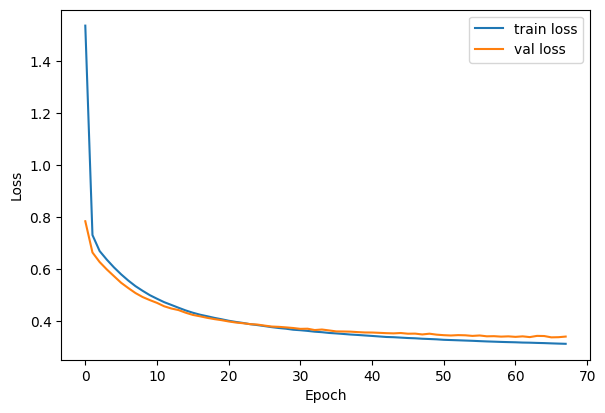

In [4]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=5,
    mode='min',
    restore_best_weights=True,
)
history = cnn_sparse.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=128, callbacks=[early_stop])

plt.figure(figsize=(15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label='train loss')
axes.plot(history.history['val_loss'], label='val loss')
axes.legend(loc="upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

Epoch 1/200
391/391 [==============================] - 3s 6ms/step - loss: 1.9168 - accuracy: 0.3574 - val_loss: 1.4539 - val_accuracy: 0.5412
Epoch 2/200
391/391 [==============================] - 2s 6ms/step - loss: 1.2370 - accuracy: 0.5972 - val_loss: 1.0745 - val_accuracy: 0.6435
Epoch 3/200
391/391 [==============================] - 2s 6ms/step - loss: 1.0146 - accuracy: 0.6633 - val_loss: 0.9405 - val_accuracy: 0.6960
Epoch 4/200
391/391 [==============================] - 2s 6ms/step - loss: 0.9013 - accuracy: 0.7031 - val_loss: 0.8431 - val_accuracy: 0.7263
Epoch 5/200
391/391 [==============================] - 2s 6ms/step - loss: 0.8251 - accuracy: 0.7284 - val_loss: 0.7926 - val_accuracy: 0.7456
Epoch 6/200
391/391 [==============================] - 2s 6ms/step - loss: 0.7744 - accuracy: 0.7452 - val_loss: 0.7474 - val_accuracy: 0.7613
Epoch 7/200
391/391 [==============================] - 2s 6ms/step - loss: 0.7371 - accuracy: 0.7573 - val_loss: 0.7168 - val_accuracy: 0.7703

Text(0, 0.5, 'Loss')

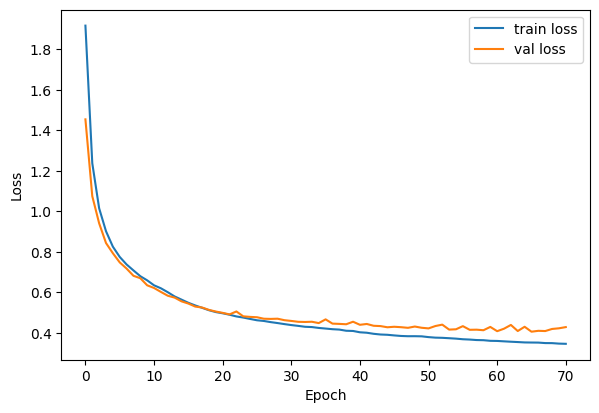

In [5]:
history = cnn_full.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=128, callbacks=[early_stop])

plt.figure(figsize=(15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label='train loss')
axes.plot(history.history['val_loss'], label='val loss')
axes.legend(loc="upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [6]:
y_pred_sparse = cnn_sparse.predict(x_test)
y_pred_full = cnn_full.predict(x_test)
print("accuracy (sparse cnn) = {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_sparse, axis=1))))
print("accuracy (full cnn) = {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_full, axis=1))))

313/313 [==============================] - 1s 2ms/step
accuracy (sparse cnn) = 0.8904
accuracy (full cnn) = 0.8666


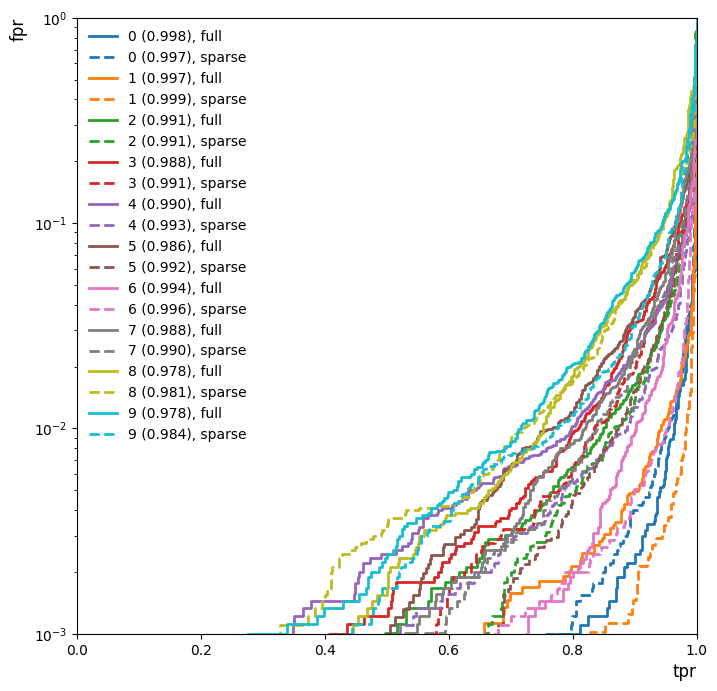

In [7]:
def plot_roc(y_test, y_pred_sparse, y_pred_full, labels):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for x, label in enumerate(labels):
        color = colors[x % len(colors)]
        fpr_full, tpr_full, _ = roc_curve(y_test[:, x], y_pred_full[:, x])
        plt.plot(tpr_full, fpr_full, label='{0} ({1:.3f}), full'.format(label, auc(fpr_full, tpr_full)), linestyle='-', lw=2, color=color)
        fpr_sparse, tpr_sparse, _ = roc_curve(y_test[:, x], y_pred_sparse[:, x])
        plt.plot(tpr_sparse, fpr_sparse, label='{0} ({1:.3f}), sparse'.format(label, auc(fpr_sparse, tpr_sparse)), linestyle='--', lw=2, color=color)
    plt.semilogy()
    plt.xlabel("tpr", size=12, loc='right')
    plt.ylabel("fpr", size=12, loc='top')
    plt.xlim(0., 1)
    plt.ylim(0.001, 1)
    plt.legend(loc='best', framealpha=0., prop={'size': 10})

plt.figure(figsize=(8, 8))
plot_roc(y_test, y_pred_sparse, y_pred_full, ['0','1','2','3','4','5','6','7','8','9'])

1/1 [==============================] - 0s 105ms/step


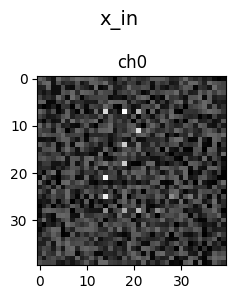

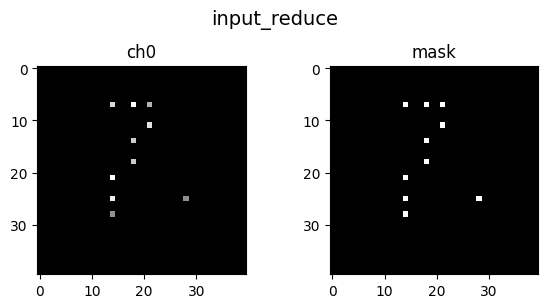

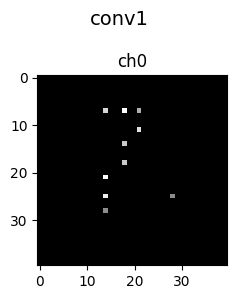

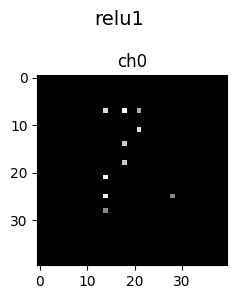

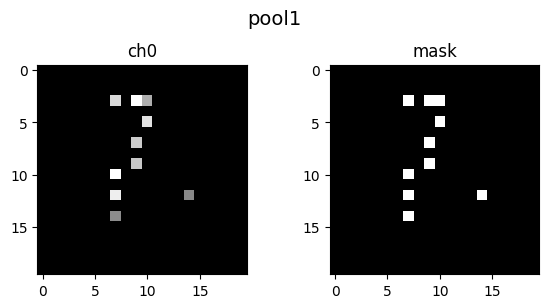

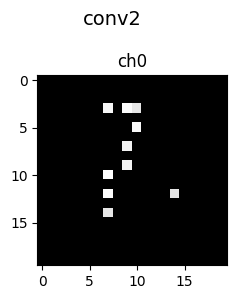

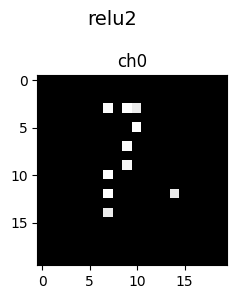

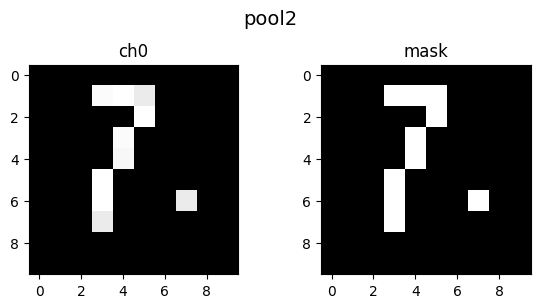

In [8]:
layer_names = [
    'x_in', 'input_reduce',
    'conv1', 'relu1', 'pool1',
    'conv2', 'relu2', 'pool2',
]

plot_tensors = []
plot_names = []
for name in layer_names:
    layer = cnn_sparse.get_layer(name)
    output = layer.output
    if isinstance(output, (list, tuple)):
        plot_tensors.append(output[0])
        plot_names.append(f'{name} (x_reduced)')
        plot_tensors.append(output[1])
        plot_names.append(f'{name} (x_mask)')
    else:
        plot_tensors.append(output)
        plot_names.append(name)

model_cnnpart = models.Model(inputs=cnn_sparse.input, outputs=plot_tensors)
layers_pred = model_cnnpart.predict(x_test[1:2])

i = 0
while i < len(plot_names):
    name = plot_names[i]

    if "(x_reduced)" in name and i+1 < len(plot_names) and "(x_mask)" in plot_names[i+1]:
        out_r = layers_pred[i] # (1, h, w, c)
        out_m = layers_pred[i+1] # (1, h, w, 1)

        arr_r = out_r[0] # (h, w, c)
        arr_m = out_m[0,...,0] # (h, w)
        h, w, c = arr_r.shape

        fig, axes = plt.subplots(1, c+1, figsize=((c+1)*3, 3))
        fig.suptitle(name.replace(" (x_reduced)", ""), fontsize=14)

        for ch in range(c):
            ax = axes[ch]
            ax.imshow(arr_r[..., ch], cmap='gray')
            ax.set_title(f"ch{ch}")

        axm = axes[c]
        axm.imshow(arr_m, cmap='gray')
        axm.set_title("mask")

        plt.tight_layout()
        plt.show()

        i += 2
        continue

    out = layers_pred[i]
    arr = out[0]

    if arr.ndim == 2:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        fig.suptitle(name, fontsize=14)
        ax.imshow(arr, cmap='gray')
        ax.set_title("ch0")
        plt.tight_layout()
        plt.show()

    elif arr.ndim == 3:
        h, w, c = arr.shape
        fig, axes = plt.subplots(1, c, figsize=(c*3, 3))
        fig.suptitle(name, fontsize=14)
        for ch in range(c):
            ax = axes[ch] if c>1 else axes
            ax.imshow(arr[..., ch], cmap='gray')
            ax.set_title(f"ch{ch}")
        plt.tight_layout()
        plt.show()

    i += 1

In [9]:
cnn_full.save_weights('weights/mnist_full0.h5')
cnn_sparse.save_weights('weights/mnist_sparse0.h5')

In [10]:
cnn_full = build_cnn(is_sparse=False)
cnn_sparse = build_cnn(is_sparse=True)

cnn_full.load_weights('weights/mnist_full0.h5')
cnn_sparse.load_weights('weights/mnist_sparse0.h5')

## hls

In [11]:
x_in = keras.Input(shape=cnn_sparse.input_shape[1:], name="x_in")
x = x_in
for layer in cnn_sparse.layers:
    if isinstance(layer, keras.layers.InputLayer):
        continue
    if isinstance(layer, InputReduce):
        continue
    if layer.name.startswith("mask_pool"):
        continue

    if isinstance(layer, QConv2DSparse):
        cfg = layer.conv.get_config()
        cfg["use_bias"] = True
        cfg["name"] = layer.name
        cfg["bias_quantizer"] = layer._bias_quant_cfg

        conv_full = QConv2D.from_config(cfg)
        x = conv_full(x)

        kernel_w = layer.conv.get_weights()[0]
        bias_w = keras.backend.get_value(layer.bias)
        conv_full.set_weights([kernel_w, bias_w])
    elif isinstance(layer, AveragePooling2DSparse):
        x = layer.avg_pool(x)
    else:
        x = layer(x)

cnn_sparse_forhls = keras.Model(x_in, x, name='cnn_sparse_forhls')
cnn_sparse_forhls.summary()

Model: "cnn_sparse_forhls"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_in (InputLayer)           [(None, 40, 40, 1)]       0         
                                                                 
 conv1 (QConv2D)             (None, 40, 40, 1)         10        
                                                                 
 relu1 (QActivation)         (None, 40, 40, 1)         0         
                                                                 
 pool1 (AveragePooling2D)    (None, 20, 20, 1)         0         
                                                                 
 conv2 (QConv2D)             (None, 20, 20, 1)         10        
                                                                 
 relu2 (QActivation)         (None, 20, 20, 1)         0         
                                                                 
 pool2 (AveragePooling2D)    (None, 10, 10, 1)   

/Users/hofungtsoi/miniforge3/envs/sparse/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [12]:
import hls4ml
config = hls4ml.utils.config_from_keras_model(cnn_sparse_forhls, granularity='name', backend='Vitis')
config

cnn_sparse_hls = hls4ml.converters.convert_from_keras_model(
    cnn_sparse_forhls,
    hls_config=config,
    project_name='hls_sparse',
    backend='Vitis',
    output_dir='hls_proj/sparsemnist/hls_sparse0',
    part='xcu250-figd2104-2L-e',
    #io_type='io_stream',
    io_type='io_parallel',
)

#cnn_sparse_hls.compile()
cnn_sparse_hls.write()

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'
Interpreting Model
Topology:
Layer name: x_in, layer type: InputLayer, input shapes: [[None, 40, 40, 1]], output shape: [None, 40, 40, 1]
Layer name: conv1, layer type: QConv2D, input shapes: [[None, 40, 40, 1]], output shape: [None, 40, 40, 1]
Layer name: relu1, layer type: Activation, input shapes: [[None, 40, 40, 1]], output shape: [None, 40, 40, 1]
Layer name: pool1, layer type: AveragePooling2D, input shapes: [[None, 40, 40, 1]], output shape: [None, 20, 20, 1]
Layer name: conv2, layer type: QConv2D, input shapes: [[None, 20, 20, 1]], output shape: [None, 20, 20, 1]
Layer name: relu2, layer type: Activation, input shapes: [[None, 20, 20, 1]], output shape: [None, 20, 20, 1]
Layer name: pool2, layer type: AveragePooling2D, input shapes: [[None, 20, 20, 1]], output shape: [None, 10, 10, 1]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 10, 10, 1]], output shape: [None, 100]
Layer nam

/Users/hofungtsoi/miniforge3/envs/sparse/lib/python3.10/site-packages/hls4ml/converters/__init__.py:28: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)
/Users/hofungtsoi/miniforge3/envs/sparse/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [13]:
import hls4ml
config = hls4ml.utils.config_from_keras_model(cnn_full, granularity='name', backend='Vitis')
config['LayerName']['conv1']['ParallelizationFactor'] = 400
config['LayerName']['conv2']['ParallelizationFactor'] = 200
config

cnn_full_hls = hls4ml.converters.convert_from_keras_model(
    cnn_full,
    hls_config=config,
    project_name='hls_full',
    backend='Vitis',
    output_dir='hls_proj/sparsemnist/hls_full0',
    part='xcu250-figd2104-2L-e',
    #io_type='io_stream',
    io_type='io_parallel',
)

#cnn_full_hls.compile()
cnn_full_hls.write()

Interpreting Model
Topology:
Layer name: x_in, layer type: InputLayer, input shapes: [[None, 40, 40, 1]], output shape: [None, 40, 40, 1]
Layer name: conv1, layer type: QConv2D, input shapes: [[None, 40, 40, 1]], output shape: [None, 40, 40, 1]
Layer name: relu1, layer type: Activation, input shapes: [[None, 40, 40, 1]], output shape: [None, 40, 40, 1]
Layer name: pool1, layer type: AveragePooling2D, input shapes: [[None, 40, 40, 1]], output shape: [None, 20, 20, 1]
Layer name: conv2, layer type: QConv2D, input shapes: [[None, 20, 20, 1]], output shape: [None, 20, 20, 1]
Layer name: relu2, layer type: Activation, input shapes: [[None, 20, 20, 1]], output shape: [None, 20, 20, 1]
Layer name: pool2, layer type: AveragePooling2D, input shapes: [[None, 20, 20, 1]], output shape: [None, 10, 10, 1]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 10, 10, 1]], output shape: [None, 100]
Layer name: dense1, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 128

## test bench

In [14]:
n_tb = 20
x_tb = x_test[:n_tb]
y_tb = y_pred_sparse[:n_tb]

with open("tb_input_features.dat", "w") as f:
    x_tb_flat = x_tb.reshape(n_tb, -1)
    for row in x_tb_flat:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

with open("tb_output_predictions.dat", "w") as f:
    for row in y_tb:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")